In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import hdbscan
import psycopg2 
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

# For offline use
cf.go_offline()

%matplotlib inline

from IPython.display import HTML

In [2]:
import datapackage
import pandas as pd

data_url = 'https://datahub.io/core/gold-prices/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        data = pd.read_csv(resource.descriptor['path'])
        print (data)

       Date     Price
0   1950-12    34.720
1   1951-12    34.660
2   1952-12    34.790
3   1953-12    34.850
4   1954-12    35.040
..      ...       ...
65  2015-12  1068.317
66  2016-12  1152.165
67  2017-12  1265.674
68  2018-12  1249.887
69  2019-12  1480.025

[70 rows x 2 columns]
        Date     Price
0    1950-01    34.730
1    1950-02    34.730
2    1950-03    34.730
3    1950-04    34.730
4    1950-05    34.730
..       ...       ...
842  2020-03  1593.764
843  2020-04  1680.030
844  2020-05  1715.697
845  2020-06  1734.032
846  2020-07  1840.807

[847 rows x 2 columns]
Empty DataFrame
Columns: [[{"Date": "1950-12",  "Price": 34.72}, {"Date": "1951-12",  "Price": 34.66}, {"Date": "1952-12",  "Price": 34.79}, {"Date": "1953-12",  "Price": 34.85}, {"Date": "1954-12",  "Price": 35.04}, {"Date": "1955-12",  "Price": 34.97}, {"Date": "1956-12",  "Price": 34.9}, {"Date": "1957-12",  "Price": 34.99}, {"Date": "1958-12",  "Price": 35.09}, {"Date": "1959-12",  "Price": 35.05}, {"Date"

In [3]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
data['Date'] = data[['Date']].apply(pd.to_datetime)

In [5]:
data['Month'] = pd.DatetimeIndex(data['Date']).month

In [6]:
data['Year'] = pd.DatetimeIndex(data['Date']).year

In [7]:
data.set_index('Date',inplace=True)

In [8]:
data.head()

,Price,Month,Year
Date,,,
1950-01-01,34.73,1,1950
1950-02-01,34.73,2,1950
1950-03-01,34.73,3,1950
1950-04-01,34.73,4,1950
1950-05-01,34.73,5,1950


<AxesSubplot:xlabel='Date', ylabel='Price'>

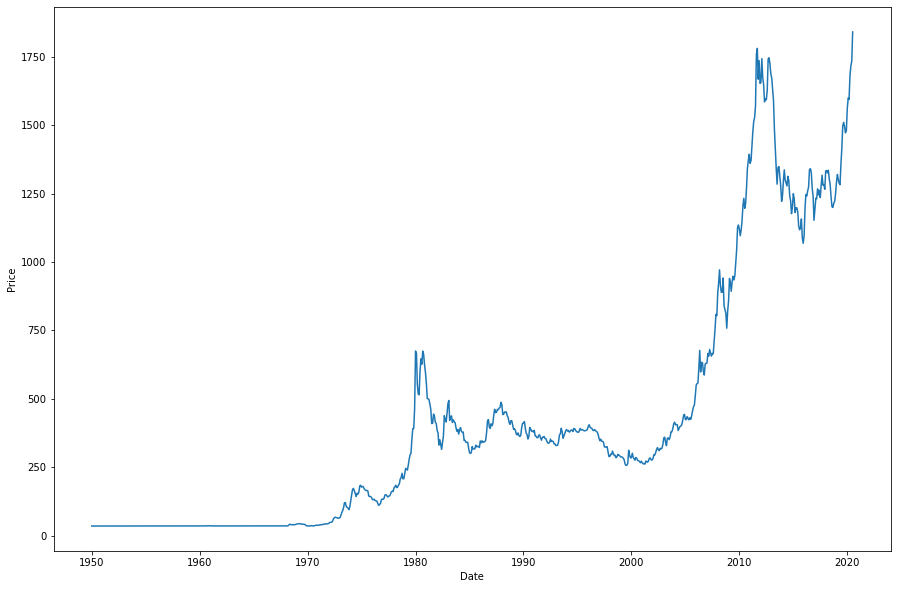

In [9]:
plt.figure(figsize=(15,10))
sns.lineplot(x = 'Date',y='Price',data=data)

In [10]:
len(data)

847

In [11]:
len(data)- 18

829

In [12]:
test_size = 18

In [13]:
test_ind = len(data)- test_size

In [14]:
train = data.iloc[:test_ind]
test = data.iloc[test_ind:]

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [21]:
# What does the first batch look like?
X,y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.37444607e-04 0.00000000e+00 0.00000000e+00 1.37444607e-04
 9.09090909e-02 0.00000000e+00 1.37444607e-04 1.81818182e-01
 0.00000000e+00 1.37444607e-04 2.72727273e-01 0.00000000e+00
 1.37444607e-04 3.63636364e-01 0.00000000e+00 1.37444607e-04
 4.54545455e-01 0.00000000e+00 1.37444607e-04 5.45454545e-01
 0.00000000e+00 1.37444607e-04 6.36363636e-01 0.00000000e+00
 1.37444607e-04 7.27272727e-01 0.00000000e+00 1.37444607e-04
 8.18181818e-01 0.00000000e+00 1.37444607e-04 9.09090909e-01
 0.00000000e+00 1.31717748e-04 1.00000000e+00 0.00000000e+00]
Predict this y: 
 [[0.00013172 0.         0.01449275]]


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [33]:
# We're only using one feature in our time series
n_features = 3

In [34]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [38]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [39]:
# fit model
model.fit_generator(generator,epochs=100,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/100
817/817 [==============================] - 10s 12ms/step - loss: 0.0660 - val_loss: 0.1034
Epoch 2/100
817/817 [==============================] - 9s 11ms/step - loss: 0.0597 - val_loss: 0.1044
Epoch 3/100
817/817 [==============================] - 6s 8ms/step - loss: 0.0597 - val_loss: 0.1034


In [40]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

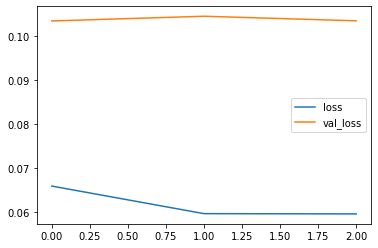

In [41]:
losses.plot()

In [42]:
first_eval_batch = scaled_train[-length:]

In [43]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [44]:
model.predict(first_eval_batch)

array([[0.61578715]], dtype=float32)

In [45]:
scaled_test[0]

array([0.73605309, 0.09090909, 1.        ])

In [55]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 1 has size 1

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

In [ ]:
test

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(data)

In [ ]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=6)

In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2020-08-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
plt.figure(figsize=(15,10))
ax = data.plot()
forecast_df.plot(ax=ax,figsize=(15,10))

In [ ]:
ax = data.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')